In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Additional Imports
import os, json, math, time
from tqdm.notebook import tqdm_notebook

In [2]:
with open('/Users/marcolaureano2/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
## Display the keys of the loaded dict
login.keys()


dict_keys(['client-id', 'api-key'])

In [3]:
import tmdbsimple as tmdb
tmdb.API_KEY =  login['api-key']

In [4]:
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['IMDB Movie Dataset Info.docx',
 'api_resultsfinal_tmdb_data_2001.csv.gz',
 'api_results',
 '.DS_Store',
 'tmdb_api_results_2001.json',
 'final_tmdb_data_2002.csv.gz',
 'api_resultstmdb_api_results_[2001, 2002].json',
 'tmdb_api_results_2002.json',
 'tmdb_api_results_[2001, 2002].json',
 'TitleRatings.tsv',
 'title-akas-us-only.csv',
 'filtered_ratings.csv',
 'preprocessed_movie_data.csv',
 'final_tmdb_data_2001.csv.gz',
 '.ipynb_checkpoints',
 'TitleBasics.tsv',
 'Data']

In [5]:
def get_movie_with_rating(movie_id):
    """Adapted from source - https://github.com/celiao/tmdbsimple"""
    # get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    
    # save the .info .releases dictionaries
    info = movie.info()
    
    releases = movie.releases()
    # loop through countries in releases
    for c in releases['countries']:
        # if the country abbreviation == US
        if c['iso_3166_1'] == 'US':
            # save a 'certification' key in info with the certification
            info['certification'] = c['certification']
    return info

In [6]:
def write_json(new_data, filename): 

    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [7]:
basics = pd.read_csv('/Users/marcolaureano2/Documents/GitHub/Movie-Database/Data/preprocessed_movie_data.csv')
basics

,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,34802,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,61114,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,67666,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
3,81515,tt0083324,movie,The White Lions,The White Lions,0,NaN,NaN,97,Drama
4,86793,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"
...,...,...,...,...,...,...,...,...,...,...
84543,10016225,tt9915130,movie,Meet John Doe,Meet John Doe,0,NaN,NaN,120,NaN
84544,10016544,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,NaN,97,"Comedy,Drama,Fantasy"
84545,10016684,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,NaN,51,Drama
84546,10016693,tt9916190,movie,Safeguard,Safeguard,0,2020.0,NaN,95,"Action,Adventure,Thriller"


In [8]:
YEARS_TO_GET = [2001,2002]
errors = [ ]

In [9]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    #Defining the JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    file_exists = os.path.isfile(JSON_FILE)
    
    if file_exists == False:
        print(f"Creating {JSON_FILE} for API results for {YEAR}.")
    # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    
    df = basics.loc[ basics['startYear'] == YEAR].copy()
    movie_ids = df['tconst'].copy()
    movie_ids
    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    previous_df
    
    # filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]
    for movie_id in tqdm_notebook(movie_ids_to_get, f"Movies from {YEAR}", position = 1, leave=True):
        try:
    # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
    # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
    # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
        
        except Exception as e:
            errors.append([YEARS_TO_GET, e])
            continue
        
    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/275 [00:00<?, ?it/s]

Movies from 2002:   0%|          | 0/332 [00:00<?, ?it/s]

In [10]:
print(f"- Total errors: {len(errors)}")

- Total errors: 607


In [11]:
final_year_df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0096056,0.0,/95U3MUDXu4xSCmVLtWgargRipDi.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}]",,109809.0,en,Crime and Punishment,...,0.0,126.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Crime and Punishment,0.0,5.333,12.0,NaN
2,tt0118926,0.0,/qR3Dk3ctnrrxkAI6I472RhamIbu.jpg,None,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",,20689.0,en,The Dancer Upstairs,...,5227348.0,132.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"An honest man caught in a world of intrigue, p...",The Dancer Upstairs,0.0,6.196,51.0,R
3,tt0119980,0.0,None,None,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",,563364.0,en,Random Shooting in LA,...,0.0,91.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,,Random Shooting in LA,0.0,0.000,0.0,
4,tt0120679,0.0,/s04Ds4xbJU7DzeGVyamccH4LoxF.jpg,None,12000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",https://www.miramax.com/movie/frida,1360.0,en,Frida,...,56298474.0,123.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,Prepare to be seduced.,Frida,0.0,7.428,1905.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,tt8302928,0.0,None,None,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",,866533.0,el,Movie Toons: Treasure Island,...,0.0,0.0,[],Released,,Movie Toons: Treasure Island,0.0,0.000,0.0,
1319,tt8474326,0.0,None,None,0.0,[],,292027.0,en,Skin Eating Jungle Vampires,...,0.0,0.0,[],Released,,Skin Eating Jungle Vampires,0.0,0.000,0.0,
1320,tt8825252,0.0,None,None,0.0,"[{'id': 14, 'name': 'Fantasy'}]",,989195.0,en,Circle of Fire: The Dark Lord Kylnor,...,0.0,45.0,[],Released,,Circle of Fire: The Dark Lord Kylnor,0.0,0.000,0.0,
1321,tt11623578,0.0,None,None,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",,1153618.0,cn,絕密檔案：人間蒸發,...,0.0,82.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,,The Untold Story - Sudden Vanished,0.0,0.000,0.0,NaN


In [12]:
import glob
# Use glob to get all filepaths that match the pattern (*=wildcard)
tmdb_files = sorted(glob.glob("Data/final_tmdb_data*.csv.gz"))
tmdb_files

['Data/final_tmdb_data_2001.csv.gz', 'Data/final_tmdb_data_2002.csv.gz']

In [13]:
# Use read_csv in a list comprehension and combine with concat to load all files
df = pd.concat([pd.read_csv(f) for f in tmdb_files] )
df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.328,1232.0,PG-13
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,tt0116916,0.0,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549.0,en,The Dark Mist,...,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.0,3.500,2.0,PG
4,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,...,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.405,132.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,tt8302928,0.0,NaN,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,866533.0,el,Movie Toons: Treasure Island,...,0.0,0.0,[],Released,NaN,Movie Toons: Treasure Island,0.0,0.000,0.0,NaN
1319,tt8474326,0.0,NaN,NaN,0.0,[],NaN,292027.0,en,Skin Eating Jungle Vampires,...,0.0,0.0,[],Released,NaN,Skin Eating Jungle Vampires,0.0,0.000,0.0,NaN
1320,tt8825252,0.0,NaN,NaN,0.0,"[{'id': 14, 'name': 'Fantasy'}]",NaN,989195.0,en,Circle of Fire: The Dark Lord Kylnor,...,0.0,45.0,[],Released,NaN,Circle of Fire: The Dark Lord Kylnor,0.0,0.000,0.0,NaN
1321,tt11623578,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",NaN,1153618.0,cn,絕密檔案：人間蒸發,...,0.0,82.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,The Untold Story - Sudden Vanished,0.0,0.000,0.0,NaN


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2710 entries, 0 to 1322
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                2710 non-null   object 
 1   adult                  2708 non-null   float64
 2   backdrop_path          1516 non-null   object 
 3   belongs_to_collection  216 non-null    object 
 4   budget                 2708 non-null   float64
 5   genres                 2708 non-null   object 
 6   homepage               216 non-null    object 
 7   id                     2708 non-null   float64
 8   original_language      2708 non-null   object 
 9   original_title         2708 non-null   object 
 10  overview               2646 non-null   object 
 11  popularity             2708 non-null   float64
 12  poster_path            2447 non-null   object 
 13  production_companies   2708 non-null   object 
 14  production_countries   2708 non-null   object 
 15  rele

In [15]:
df['budget'].value_counts()

0.0           2088
3000000.0       20
4000000.0       19
35000000.0      17
25000000.0      16
              ... 
165000.0         1
5500000.0        1
19800000.0       1
9400000.0        1
1000.0           1
Name: budget, Length: 198, dtype: int64

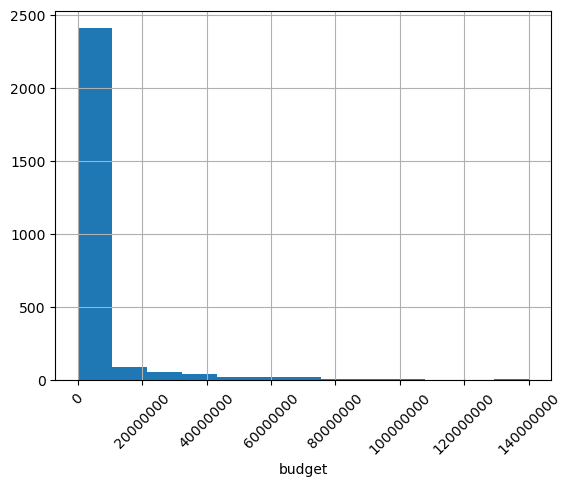

In [33]:
ax=df['budget'].hist(bins='auto')
ax.ticklabel_format(style='plain')
ax.tick_params(axis='x', rotation= 45)
ax.set_xlabel('budget');

In [16]:
no_budget_info = df['budget'] == 0

In [17]:
no_budget_info.value_counts()

True     2088
False     622
Name: budget, dtype: int64

There are 2088 movies with 0's for budget
There are 622 movies that have values for budget

In [18]:
df['revenue'].value_counts()

0.0            2192
6000000.0         3
500000.0          2
12000000.0        2
6500000.0         2
               ... 
463780.0          1
33788161.0        1
100020092.0       1
100420.0          1
2000000.0         1
Name: revenue, Length: 511, dtype: int64

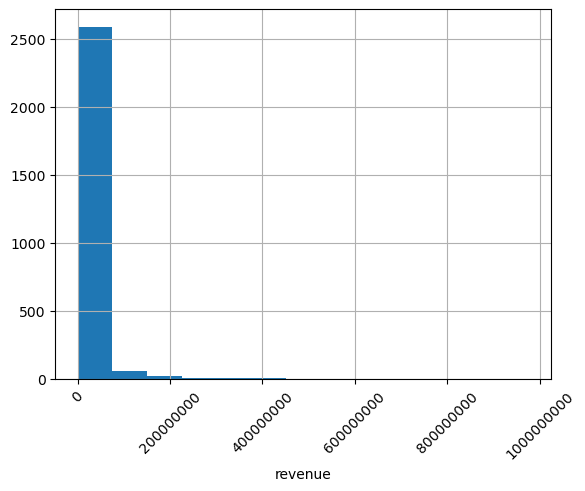

In [31]:
ax = df['revenue'].hist(bins='auto')
ax.ticklabel_format(style='plain')
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('revenue');

In [19]:
no_revenue_info = df['revenue'] == 0

In [20]:
no_revenue_info.value_counts()

True     2192
False     518
Name: revenue, dtype: int64

There are 2092 movies with 0's for revenue
There are 518 movies with values for revenue

In [21]:
missing_financial_info = no_budget_info + no_revenue_info
missing_financial_info.value_counts()

True     2302
False     408
dtype: int64

There are 2302 movies with missing financial information
There are 408 movies with financial information

In [25]:
df_with_financial_info = df[~no_financial_info]
df_with_financial_info

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0035423,0.0,/hfeiSfWYujh6MKhtGTXyK3DD4nN.jpg,NaN,48000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 14, ...",NaN,11232.0,en,Kate & Leopold,...,76019048.0,118.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,"If they lived in the same century, they'd be p...",Kate & Leopold,0.0,6.328,1232.0,PG-13
4,tt0118589,0.0,/9NZAirJahVilTiDNCHLFcdkwkiy.jpg,NaN,22000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",NaN,10696.0,en,Glitter,...,5271666.0,104.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,"In music she found her dream, her love, herself.",Glitter,0.0,4.405,132.0,PG-13
9,tt0120681,0.0,/xo2S7gRwCvWdVqM0Swv37yA2rzw.jpg,NaN,35000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,768.0,en,From Hell,...,74558115.0,122.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Only the legend will survive.,From Hell,0.0,6.684,2577.0,R
10,tt0120737,0.0,/x2RS3uTcsJJ9IfjNPcgDmukoEcQ.jpg,"{'id': 119, 'name': 'The Lord of the Rings Col...",93000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://www.lordoftherings.net/,120.0,en,The Lord of the Rings: The Fellowship of the Ring,...,871368364.0,179.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,One ring to rule them all,The Lord of the Rings: The Fellowship of the Ring,0.0,8.403,23349.0,PG-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,tt0364385,0.0,/3ZDkl8rsoLe6g4FRV9alNH5sZOt.jpg,"{'id': 1972, 'name': 'Ju-on Collection', 'post...",3500000.0,"[{'id': 27, 'name': 'Horror'}]",NaN,11838.0,ja,呪怨,...,3657876.0,92.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,When a grudge from the dead passes to the livi...,Ju-on: The Grudge,0.0,6.686,700.0,R
1156,tt0365960,0.0,/ahXtNFVHtFxvjphZN8QlHRVsu9W.jpg,NaN,20000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,27090.0,en,Zero Day,...,8466.0,92.0,"[{'english_name': 'German', 'iso_639_1': 'de',...",Released,"In high school, you're told you can do anythin...",Zero Day,0.0,7.400,79.0,NaN
1244,tt0757920,0.0,/sOkmFOVcDmH2P4GU9Mvyc4ZBC3D.jpg,NaN,10000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,44078.0,fa,Dokhtar-e shirini-foroosh,...,10000.0,105.0,"[{'english_name': 'Persian', 'iso_639_1': 'fa'...",Released,NaN,The Pastry Girl,0.0,1.000,1.0,NaN
1259,tt1039983,0.0,/7B5IQdNNyNsSwBaW9zzCT9XmAcJ.jpg,NaN,500000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,69419.0,ta,ரெட்,...,500000.0,157.0,"[{'english_name': 'Tamil', 'iso_639_1': 'ta', ...",Released,NaN,Red,0.0,5.100,7.0,NaN


In [26]:
missing_financial_info_df = df[missing_financial_info]
missing_financial_info_df

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
2,tt0114447,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",NaN,151007.0,en,The Silent Force,...,0.0,90.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They left him for dead... They should have fin...,The Silent Force,0.0,5.000,3.0,NaN
3,tt0116916,0.0,/rFpHBidSlhjflmnLu7BZilyKeQR.jpg,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,73549.0,en,The Dark Mist,...,0.0,101.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Dark Mist,0.0,3.500,2.0,PG
5,tt0118652,0.0,/mWxJEFRMvkG4UItYJkRDMgWQ08Y.jpg,NaN,1000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,17140.0,en,The Attic Expeditions,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,His search for peace of mind... will leave his...,The Attic Expeditions,0.0,5.194,31.0,R
6,tt0119004,0.0,/7xrlSPGDO4CDT6IHTctDlkYxTzw.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,37857.0,en,Don's Plum,...,6297.0,108.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Tonight's Special - Group Therapy,Don's Plum,0.0,5.257,74.0,NaN
7,tt0120166,0.0,/havCE85OV7FUMWzqAZ9x31XRRCA.jpg,NaN,0.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",NaN,50944.0,en,The Sorcerer's Apprentice,...,0.0,86.0,"[{'english_name': 'French', 'iso_639_1': 'fr',...",Released,NaN,The Sorcerer's Apprentice,0.0,4.600,11.0,NR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318,tt8302928,0.0,NaN,NaN,0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,866533.0,el,Movie Toons: Treasure Island,...,0.0,0.0,[],Released,NaN,Movie Toons: Treasure Island,0.0,0.000,0.0,NaN
1319,tt8474326,0.0,NaN,NaN,0.0,[],NaN,292027.0,en,Skin Eating Jungle Vampires,...,0.0,0.0,[],Released,NaN,Skin Eating Jungle Vampires,0.0,0.000,0.0,NaN
1320,tt8825252,0.0,NaN,NaN,0.0,"[{'id': 14, 'name': 'Fantasy'}]",NaN,989195.0,en,Circle of Fire: The Dark Lord Kylnor,...,0.0,45.0,[],Released,NaN,Circle of Fire: The Dark Lord Kylnor,0.0,0.000,0.0,NaN
1321,tt11623578,0.0,NaN,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}, {'id': 9648, ...",NaN,1153618.0,cn,絕密檔案：人間蒸發,...,0.0,82.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,NaN,The Untold Story - Sudden Vanished,0.0,0.000,0.0,NaN
